# housekeeping

In [1]:
from dataclasses import dataclass
import os
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
RANDOM_SEED = 1013
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
    hdi_prob=0.89
)

# モデル定義

In [3]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

In [4]:
@dataclass
class BinomialData:
    trials: int
    successes: int

In [5]:
class ConversionModelTwoVariant:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=2)
            obs = pm.Binomial("y", n=trials, p=p, shape=2, observed=successes)
            reluplift = pm.Deterministic("reluplift_b", p[1] / p[0] - 1)
        return model

# 事前予測チェック

In [6]:
weak_prior = ConversionModelTwoVariant(BetaPrior(alpha=100, beta=100))
strong_prior = ConversionModelTwoVariant(BetaPrior(alpha=10000, beta=10000))

In [7]:
with weak_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    weak_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

Sampling: [p, y]


In [8]:
with strong_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    strong_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

Sampling: [p, y]


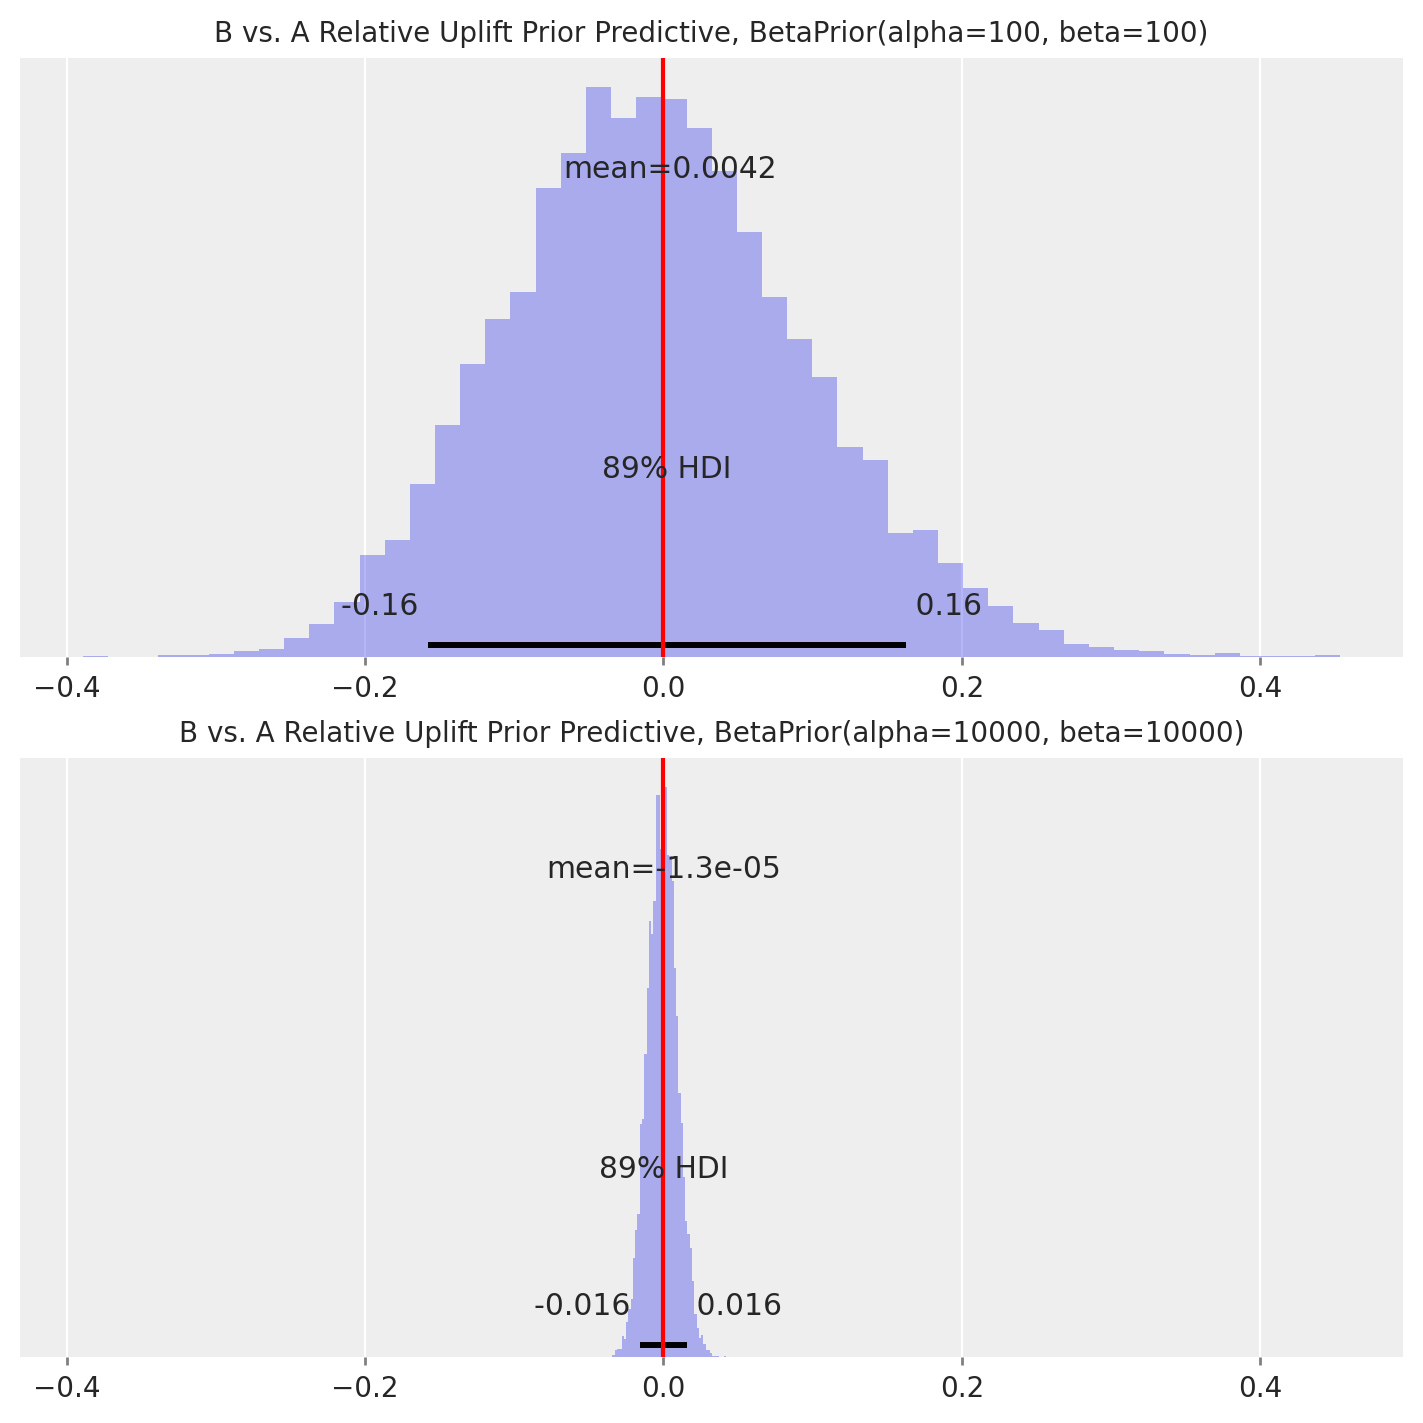

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
az.plot_posterior(weak_prior_predictive["reluplift_b"], ax=axs[0], **plotting_defaults)
axs[0].set_title(f"B vs. A Relative Uplift Prior Predictive, {weak_prior.priors}", fontsize=10)
axs[0].axvline(x=0, color="red")
az.plot_posterior(strong_prior_predictive["reluplift_b"], ax=axs[1], **plotting_defaults)
axs[1].set_title(f"B vs. A Relative Uplift Prior Predictive, {strong_prior.priors}", fontsize=10)
axs[1].axvline(x=0, color="red")

# データ

In [10]:
path = os.getcwd()  # works only in case it's launched from examples folder
fileloc = path + '/../GoalsAndGaps/Goals_new/dataset/others/dataset_causalforest.txt'
print(fileloc)

/Users/domolm/Library/CloudStorage/GoogleDrive-domokomod5@gmail.com/My Drive/Learning/研究計画/ATE_GAG/../GoalsAndGaps/Goals_new/dataset/others/dataset_causalforest.txt


In [11]:
df = pd.read_table(fileloc)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   treat                      1217 non-null   int64  
 1   lictec2                    1217 non-null   int64  
 2   motivation                 687 non-null    float64
 3   barriers                   687 non-null    float64
 4   consiglio_lictec2          1217 non-null   int64  
 5   stdmatIII                  1094 non-null   float64
 6   stditaIII                  1094 non-null   float64
 7   school                     1217 non-null   int64  
 8   perc_participation_orient  597 non-null    float64
 9   perc_participation_calp    579 non-null    float64
 10  perc_participation         597 non-null    float64
 11  late                       1217 non-null   int64  
 12  female                     1217 non-null   int64  
 13  immigrato_prima_gen        1217 non-null   int64

In [12]:
def data_generater(df) -> List[BinomialData]:
    control = df[df['treat']==0].copy()
    control_trials = control.shape[0]
    control_successes = control['lictec2'].sum()
    treatment = df[df['treat']==1].copy()
    treatment_trials = treatment.shape[0]
    treatment_successes = treatment['lictec2'].sum()
    data_c = BinomialData(control_trials, control_successes)
    data_t = BinomialData(treatment_trials, treatment_successes)
    return [data_c, data_t]


In [13]:
def gender_data_generater(df, female:bool) -> List[BinomialData]:
    if female:
        control = df[df['treat']==0].copy()
        control = control[control['female']==1].copy()
        treatment = df[df['treat']==1].copy()
        treatment = treatment[treatment['female']==1].copy()
    else:
        control = df[df['treat']==0].copy()
        control = control[control['female']==0].copy()
        treatment = df[df['treat']==1].copy()
        treatment = treatment[treatment['female']==0].copy()
    control_trials = control.shape[0]
    control_successes = control['lictec2'].sum()
    treatment_trials = treatment.shape[0]
    treatment_successes = treatment['lictec2'].sum()
    data_c = BinomialData(control_trials, control_successes)
    data_t = BinomialData(treatment_trials, treatment_successes)

    return [data_c, data_t]


# Relative Uplift 計算

In [14]:
def run_scenario_twovariant(
    data: List[BinomialData],
    weak_prior: BetaPrior,
    strong_prior: BetaPrior,
) -> None:
    with ConversionModelTwoVariant(priors=weak_prior).create_model(data):
        trace_weak = pm.sample(draws=5000, random_seed=RANDOM_SEED)
    with ConversionModelTwoVariant(priors=strong_prior).create_model(data):
        trace_strong = pm.sample(draws=5000, random_seed=RANDOM_SEED)

    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    az.plot_posterior(trace_weak.posterior["reluplift_b"], ax=axs[0], **plotting_defaults)
    axs[0].set_title(f"{weak_prior}", fontsize=10)
    axs[0].axvline(x=0, color="red")
    az.plot_posterior(trace_strong.posterior["reluplift_b"], ax=axs[1], **plotting_defaults)
    axs[1].set_title(f"{strong_prior}", fontsize=10)
    axs[1].axvline(x=0, color="red")
    fig.suptitle("B vs. A Rel Uplift")
    return trace_weak, trace_strong

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


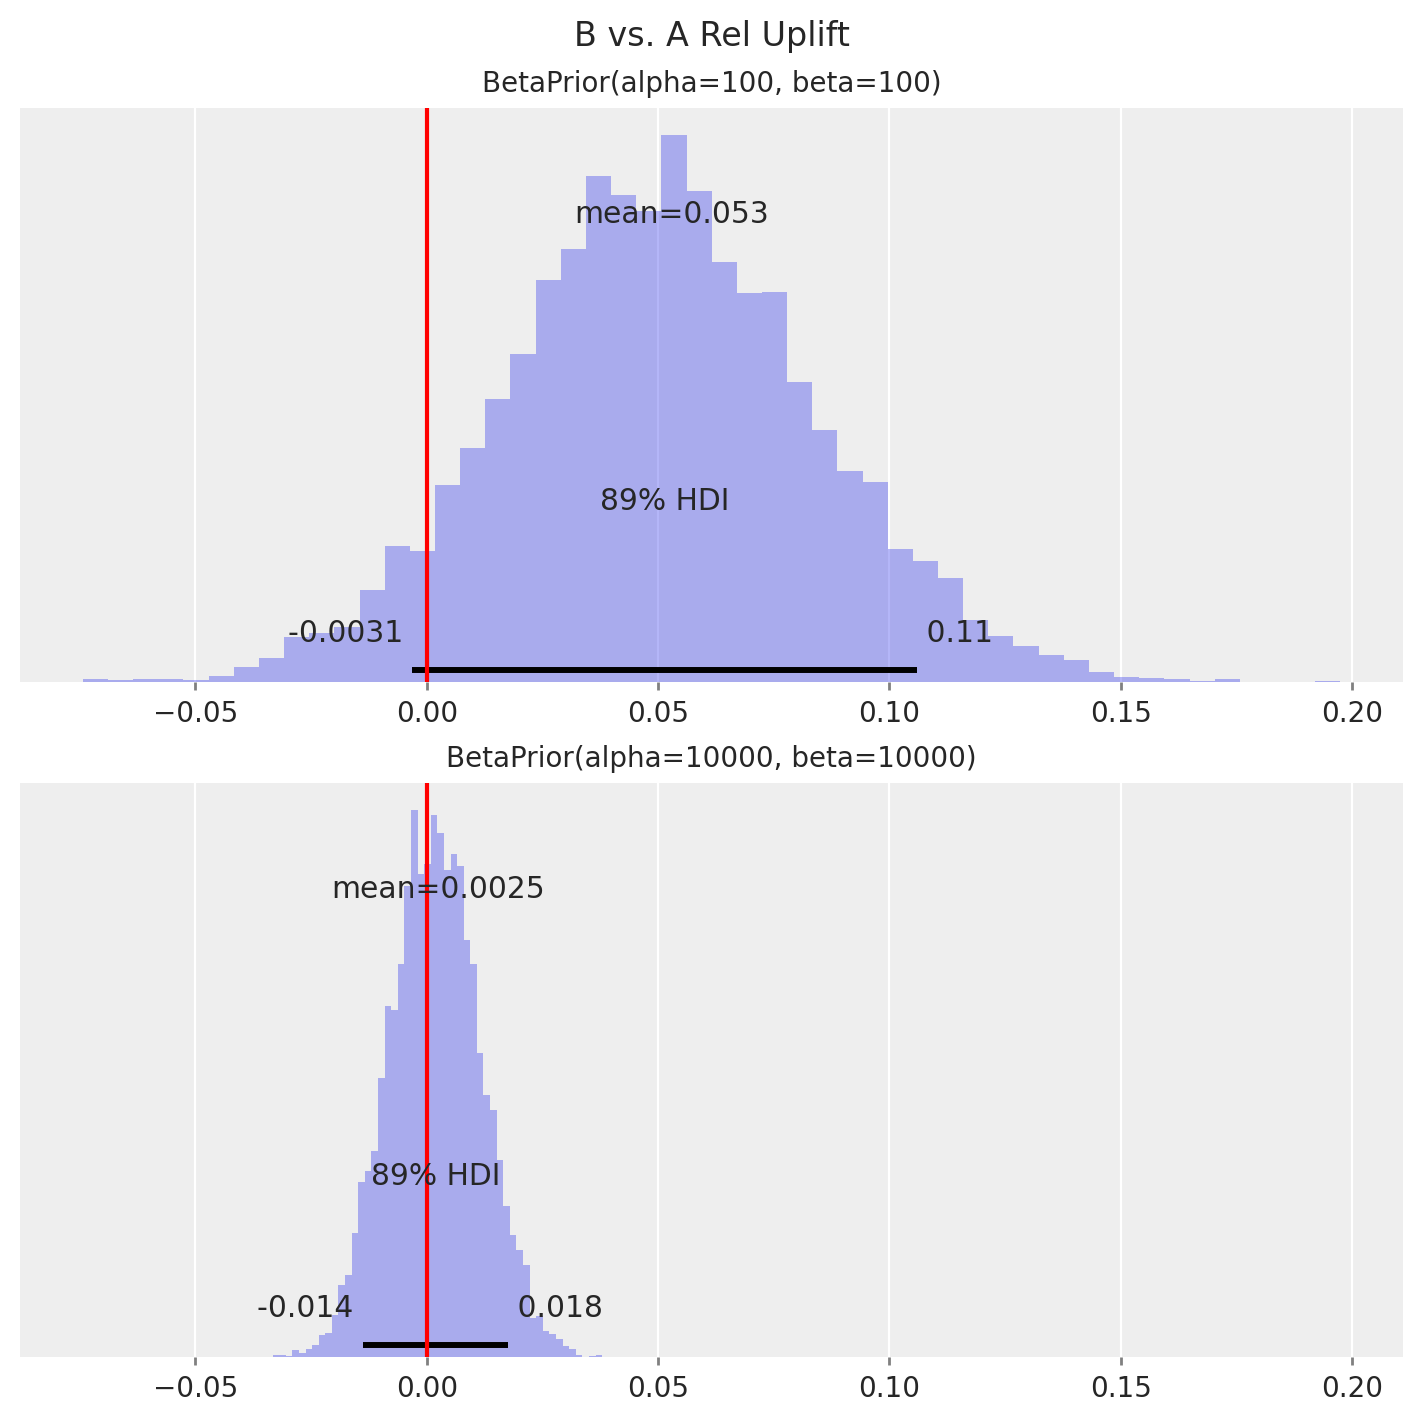

In [15]:
trace_weak, trace_strong = run_scenario_twovariant(
    data=data_generater(df),
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

In [16]:
az.summary(trace_weak)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.689,0.016,0.659,0.720,0.0,0.0,9090.0,6887.0,1.0
p[1],0.725,0.016,0.695,0.754,0.0,0.0,9627.0,6773.0,1.0
reluplift_b,0.053,0.034,-0.012,0.116,0.0,0.0,9678.0,6992.0,1.0


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'reluplift_b'}>,
        <Axes: title={'center': 'reluplift_b'}>]], dtype=object)

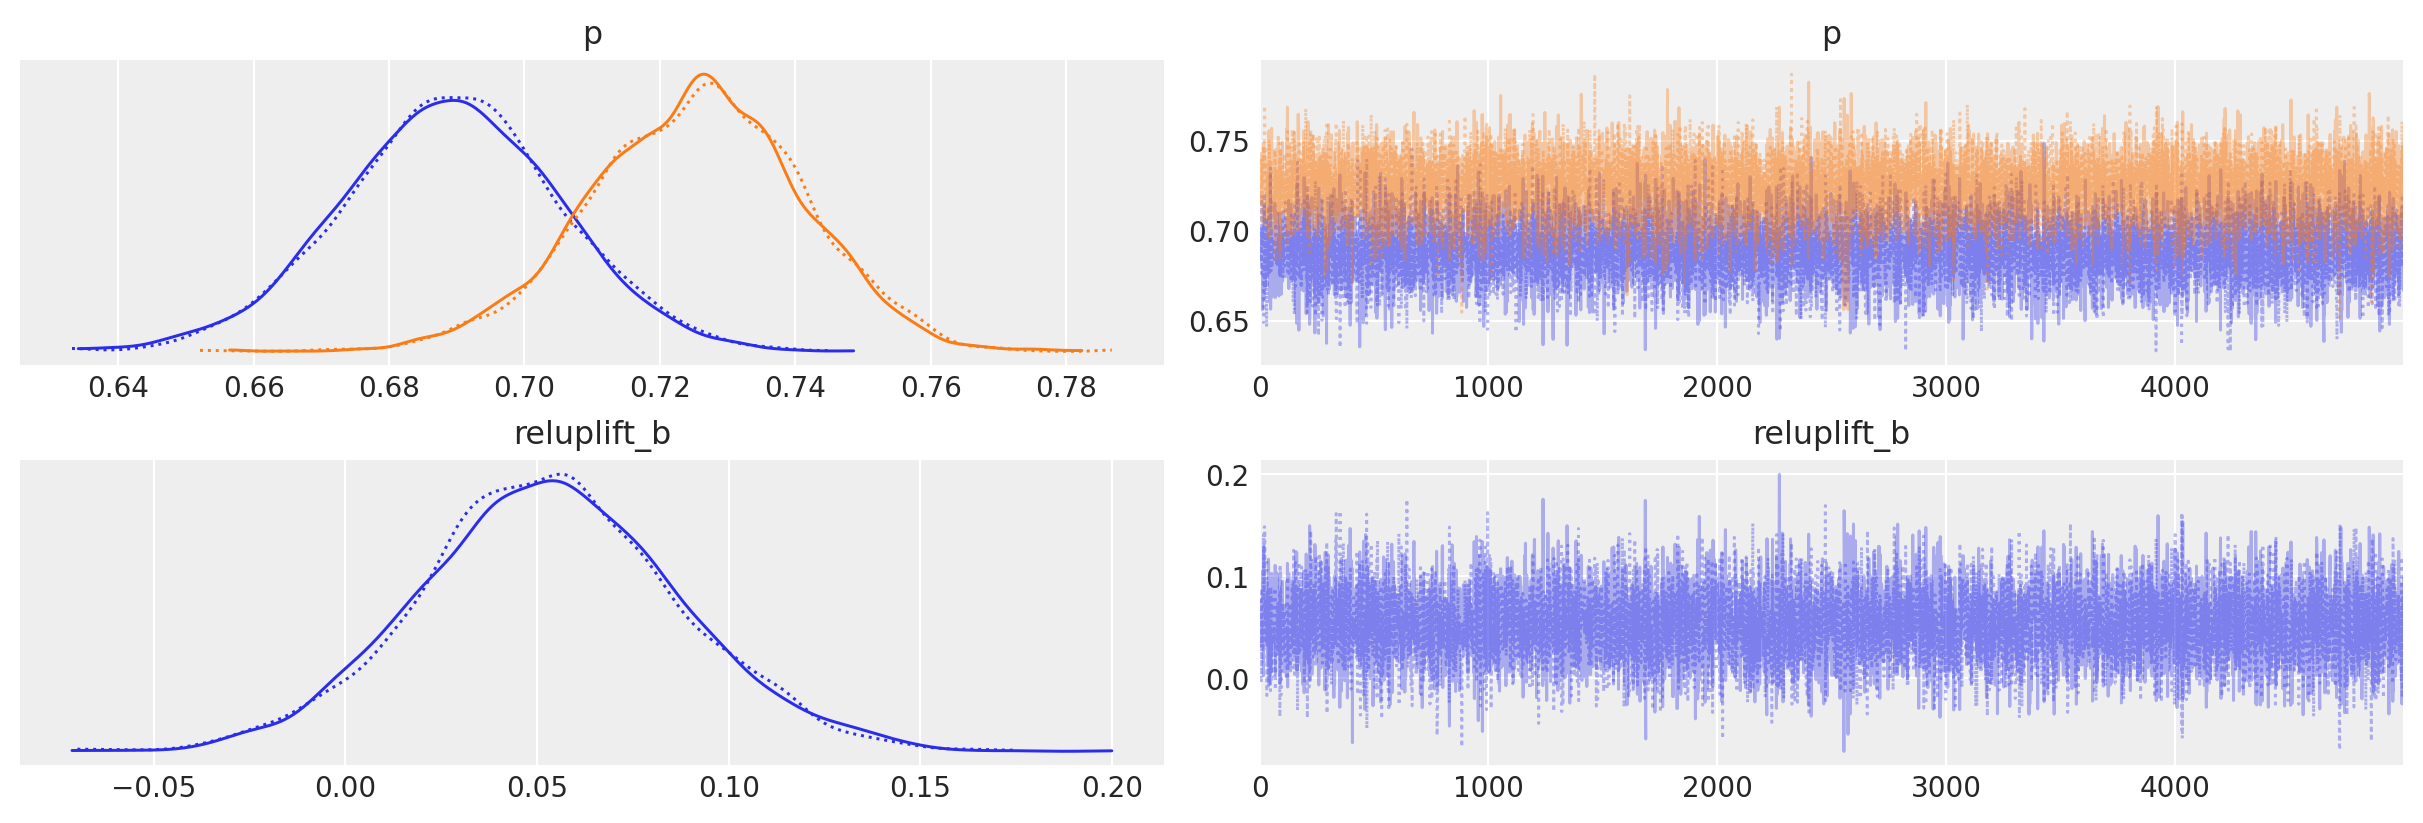

In [17]:
az.plot_trace(trace_weak)

# gender 別 Relative Uplift 計算

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


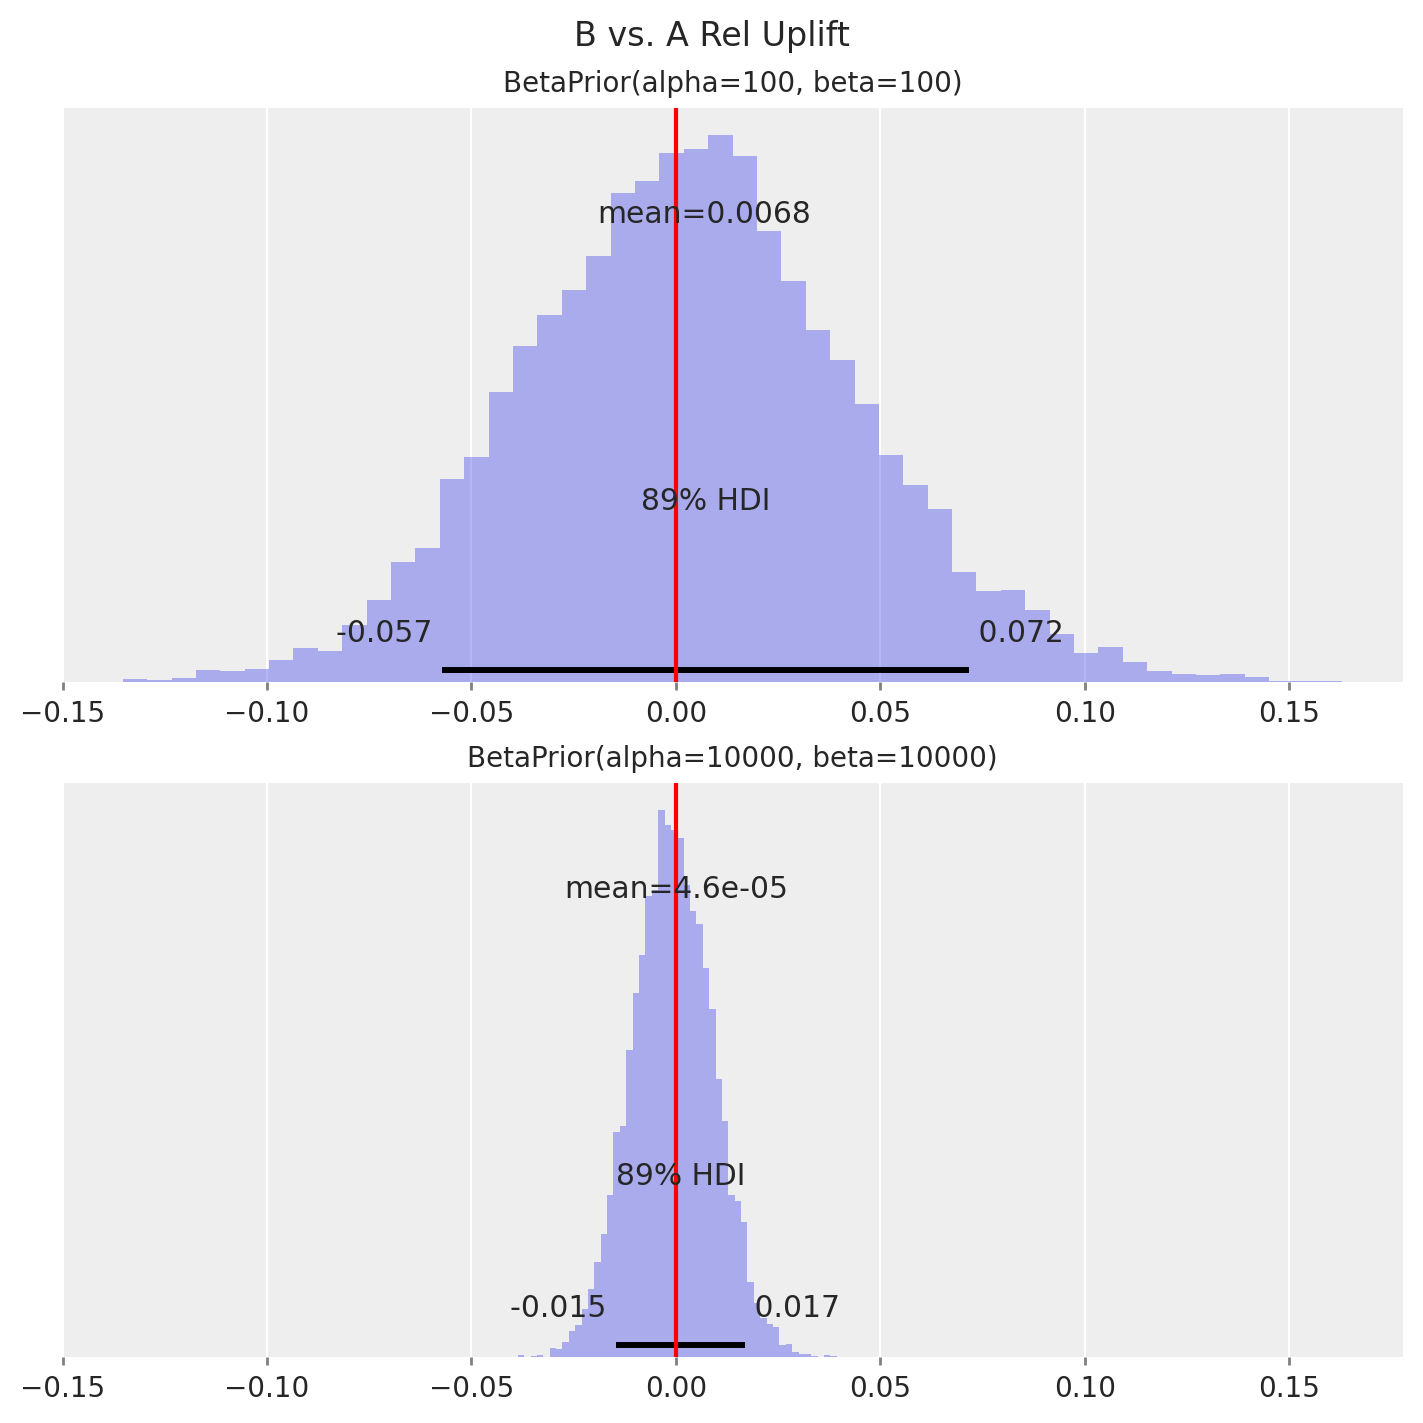

In [18]:
# Female
female_trace_weak, female_trace_strong = run_scenario_twovariant(
    data=gender_data_generater(df, female=True),
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


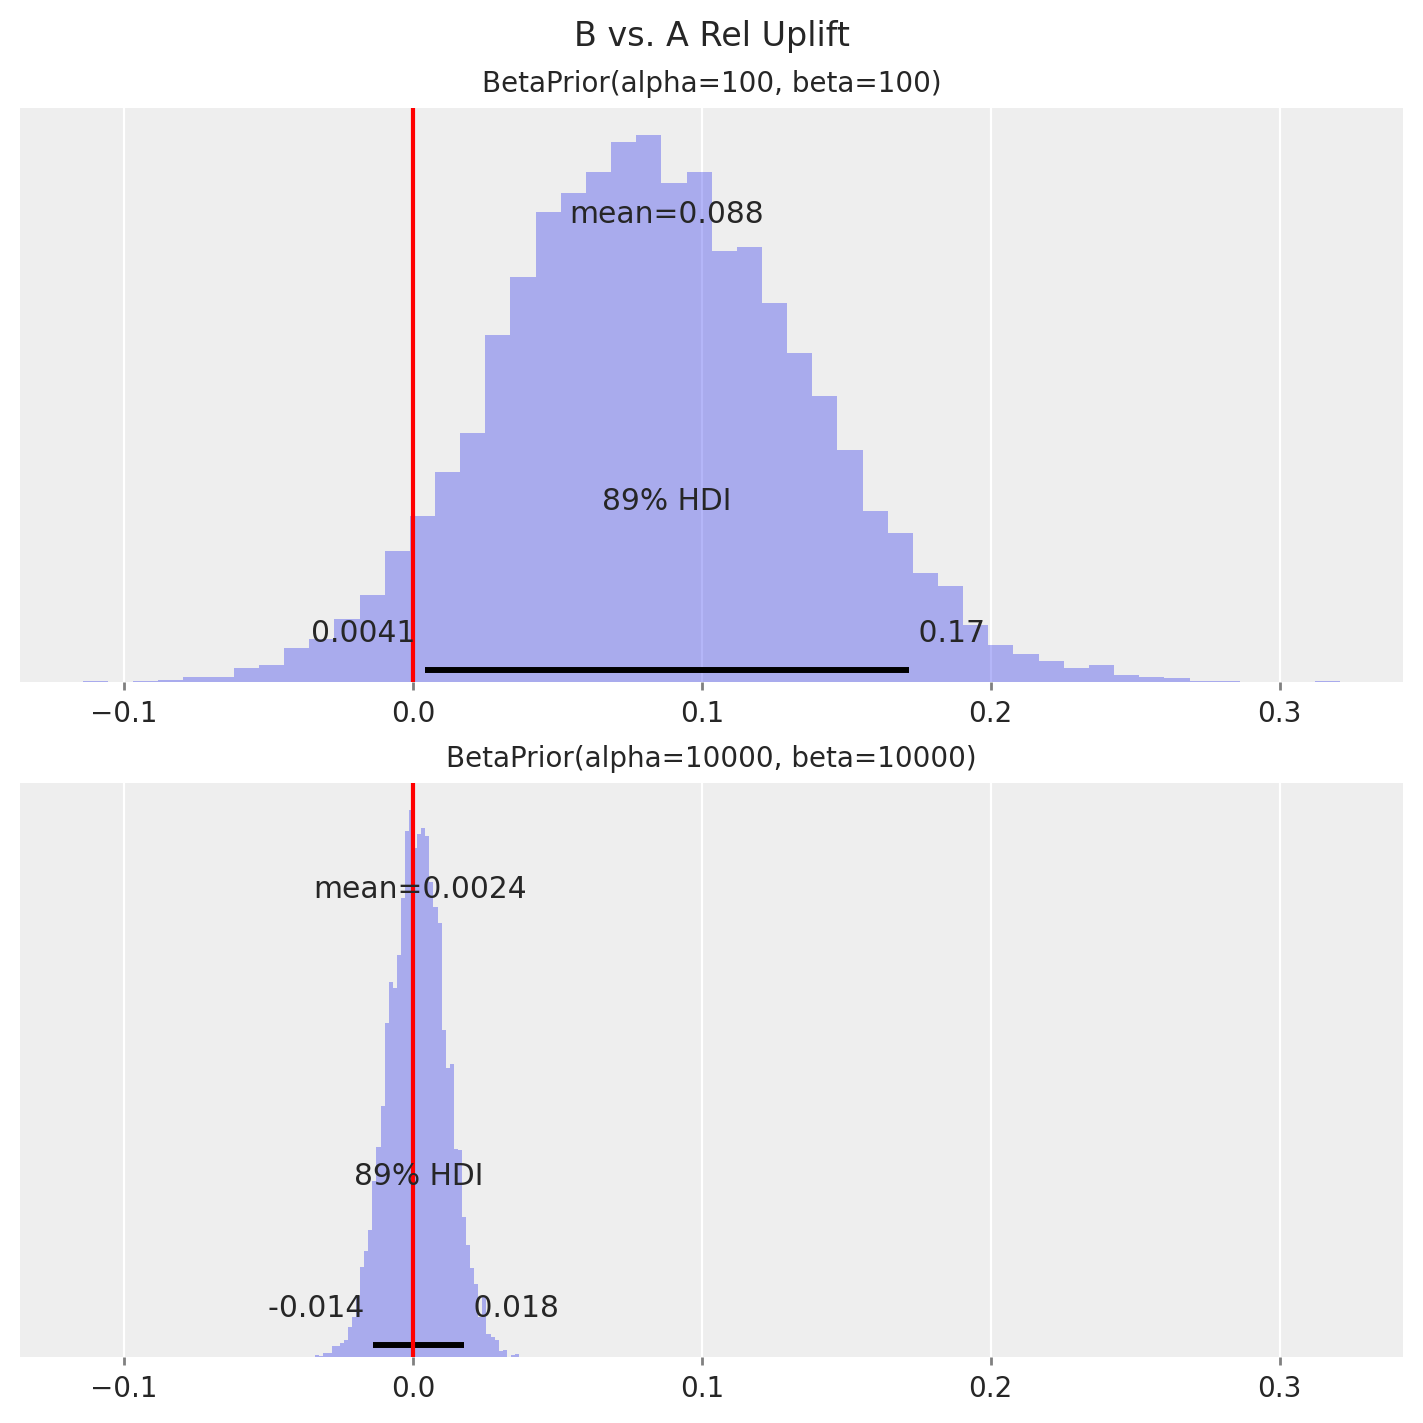

In [19]:
# Male
male_trace_weak, male_trace_strong = run_scenario_twovariant(
    data=gender_data_generater(df, female=False),
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

# ATE

In [20]:
class ATE:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=2)
            obs = pm.Binomial("y", n=trials, p=p, shape=2, observed=successes)
            ATE = pm.Deterministic("ATE", p[1] - p[0])
        return model

In [21]:
def run_ATE(
    data: List[BinomialData],
    weak_prior: BetaPrior,
    strong_prior: BetaPrior,
) -> None:
    with ATE(priors=weak_prior).create_model(data):
        trace_weak = pm.sample(draws=5000, random_seed=RANDOM_SEED)
    with ATE(priors=strong_prior).create_model(data):
        trace_strong = pm.sample(draws=5000, random_seed=RANDOM_SEED)

    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    az.plot_posterior(trace_weak.posterior["ATE"], ax=axs[0], **plotting_defaults)
    axs[0].set_title(f"{weak_prior}", fontsize=10)
    axs[0].axvline(x=0, color="red")
    az.plot_posterior(trace_strong.posterior["ATE"], ax=axs[1], **plotting_defaults)
    axs[1].set_title(f"{strong_prior}", fontsize=10)
    axs[1].axvline(x=0, color="red")
    fig.suptitle("$p_{treatment} - p_{control}$")
    return trace_weak, trace_strong

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


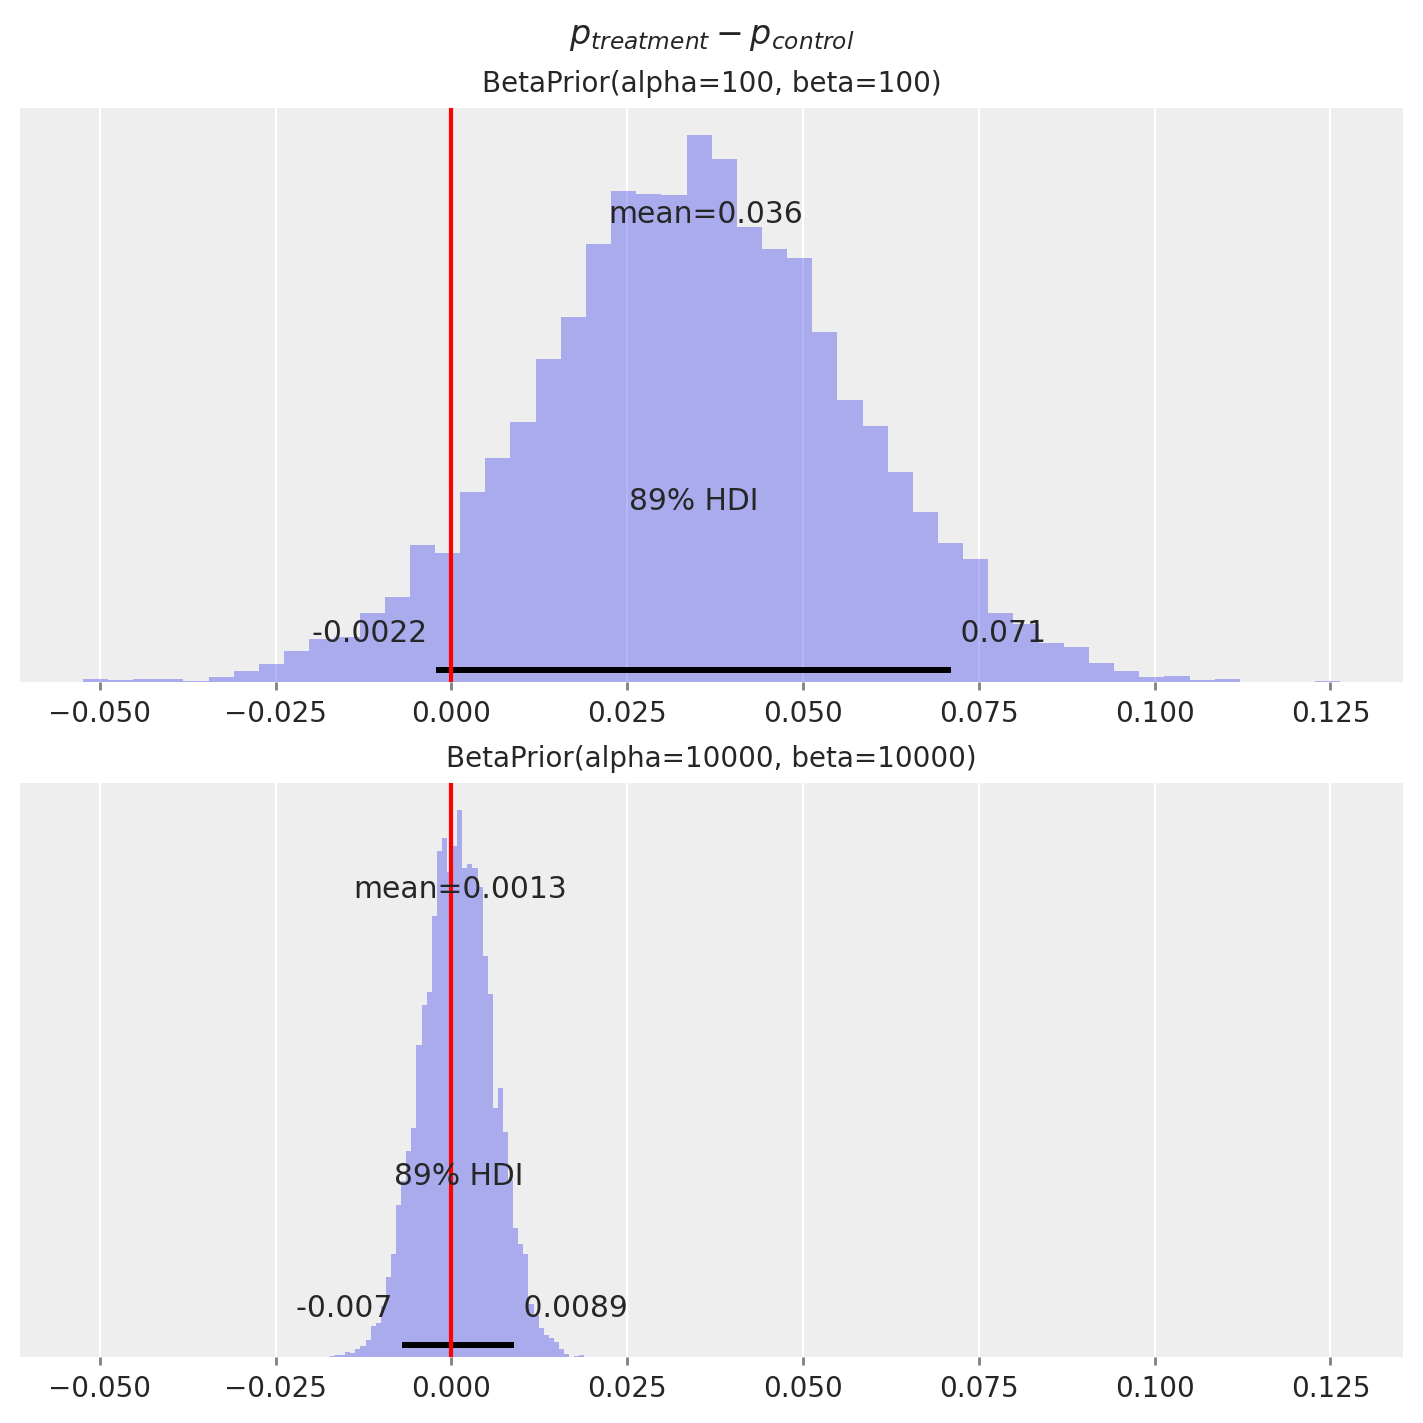

In [22]:
ATE_weak, ATE_strong = run_ATE(
    data=data_generater(df),
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'ATE'}>, <Axes: title={'center': 'ATE'}>]],
      dtype=object)

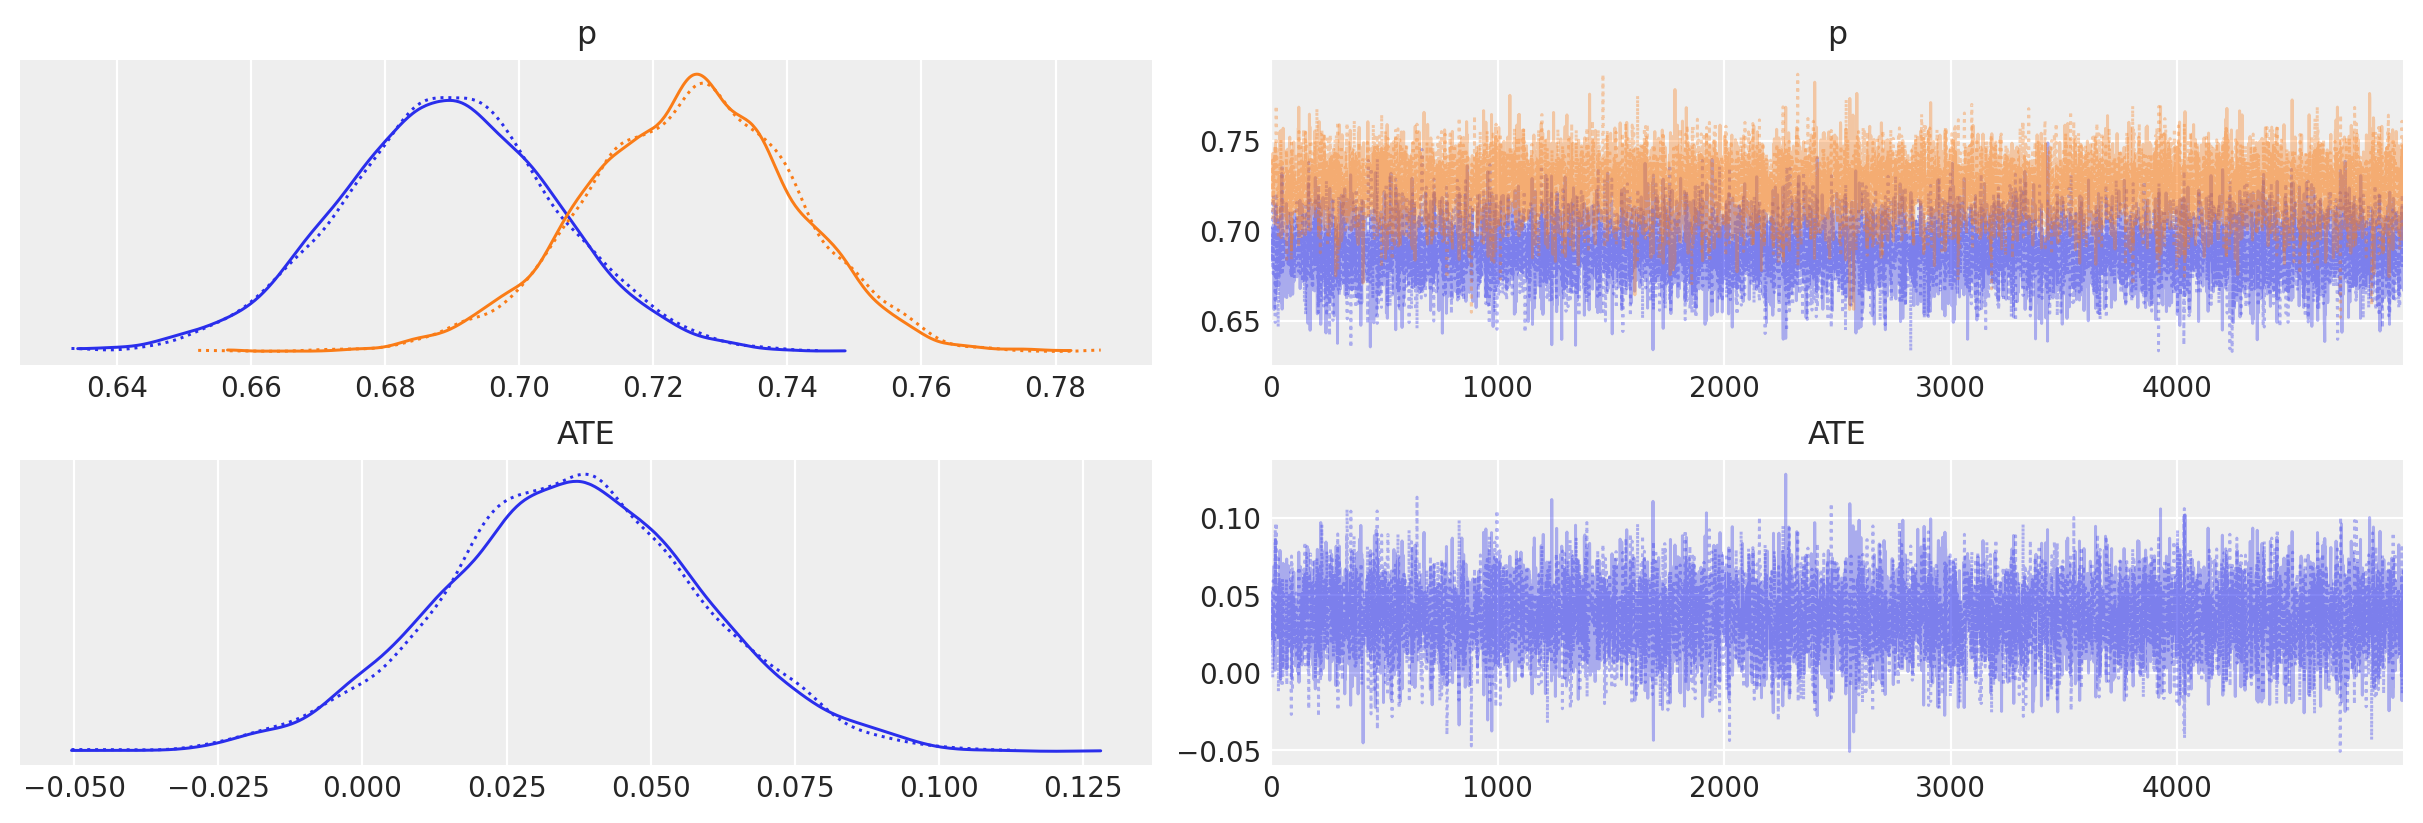

In [23]:
az.plot_trace(ATE_weak)

In [24]:
az.summary(ATE_weak)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.689,0.016,0.659,0.720,0.0,0.0,9090.0,6887.0,1.0
p[1],0.725,0.016,0.695,0.754,0.0,0.0,9627.0,6773.0,1.0
ATE,0.036,0.023,-0.006,0.079,0.0,0.0,9711.0,7161.0,1.0


# gender 別 ATE 計算

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


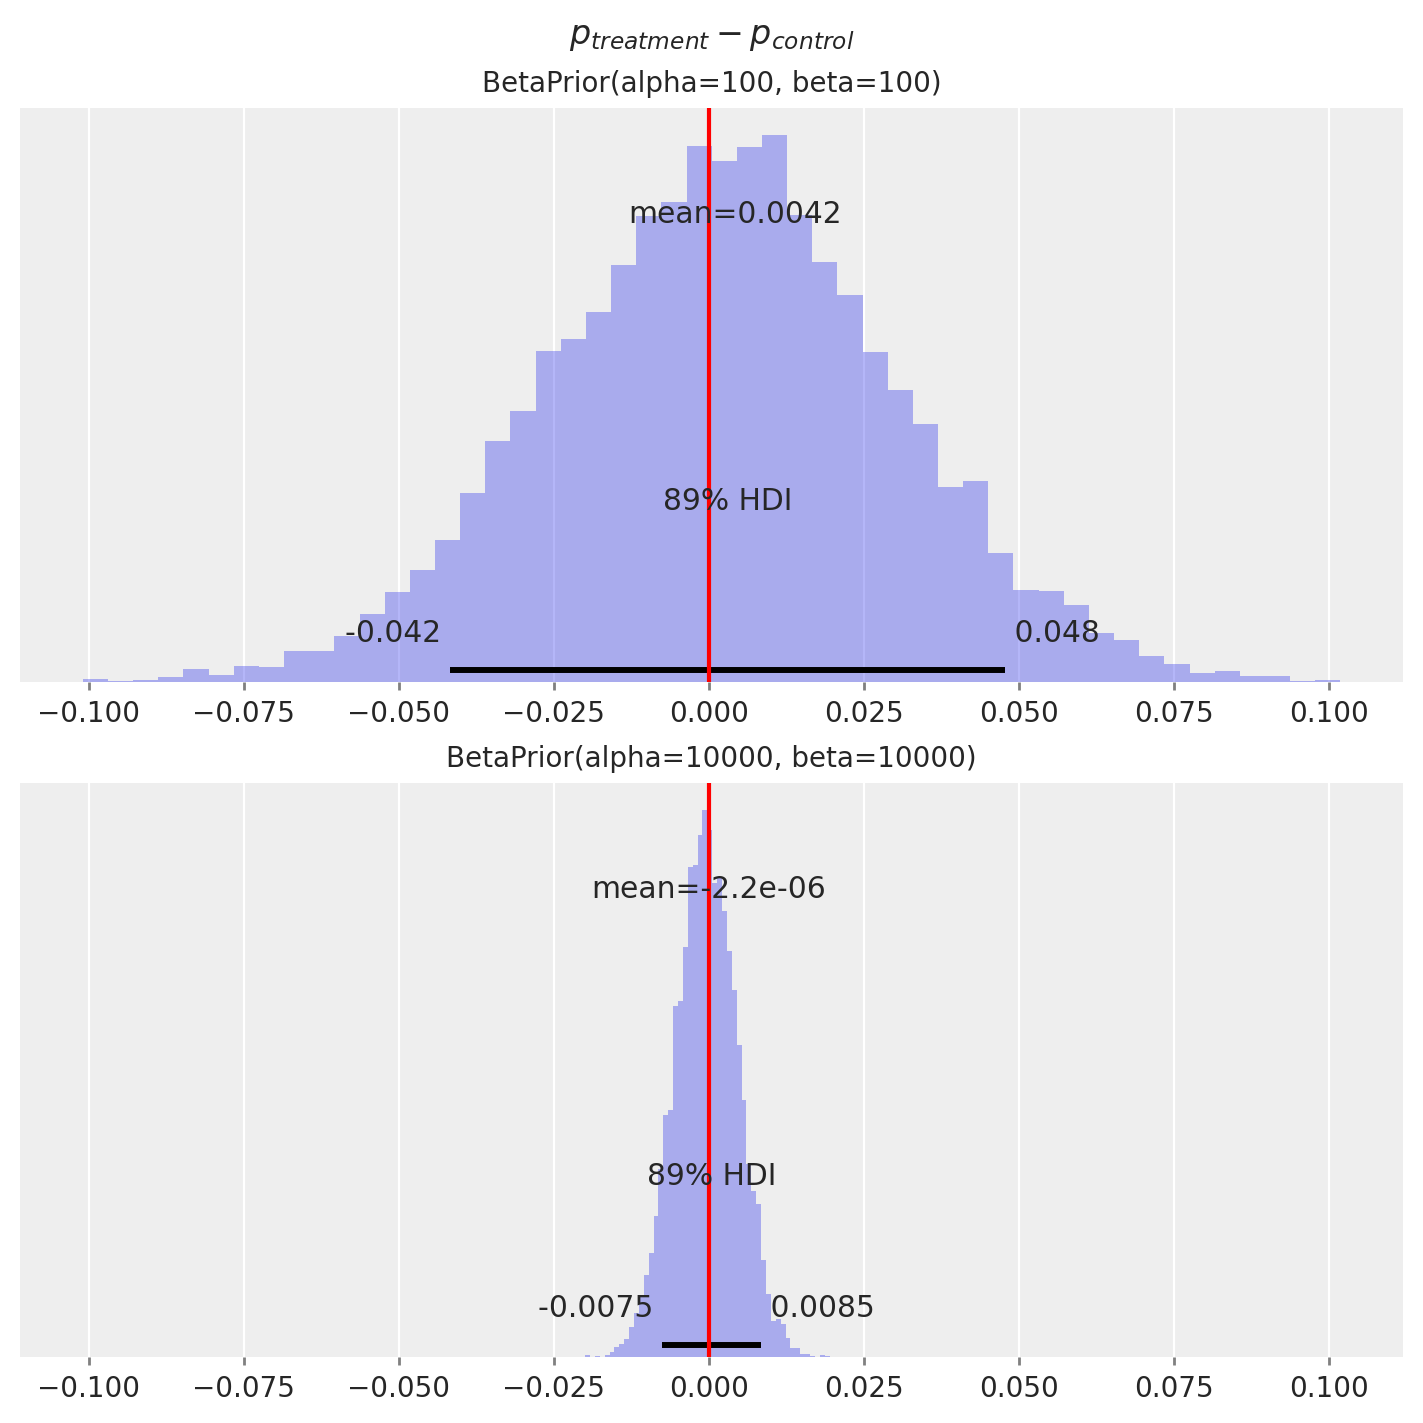

In [25]:
# female
female_ATE_weak, female_ATE_strong = run_ATE(
    data=gender_data_generater(df, female=True),
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


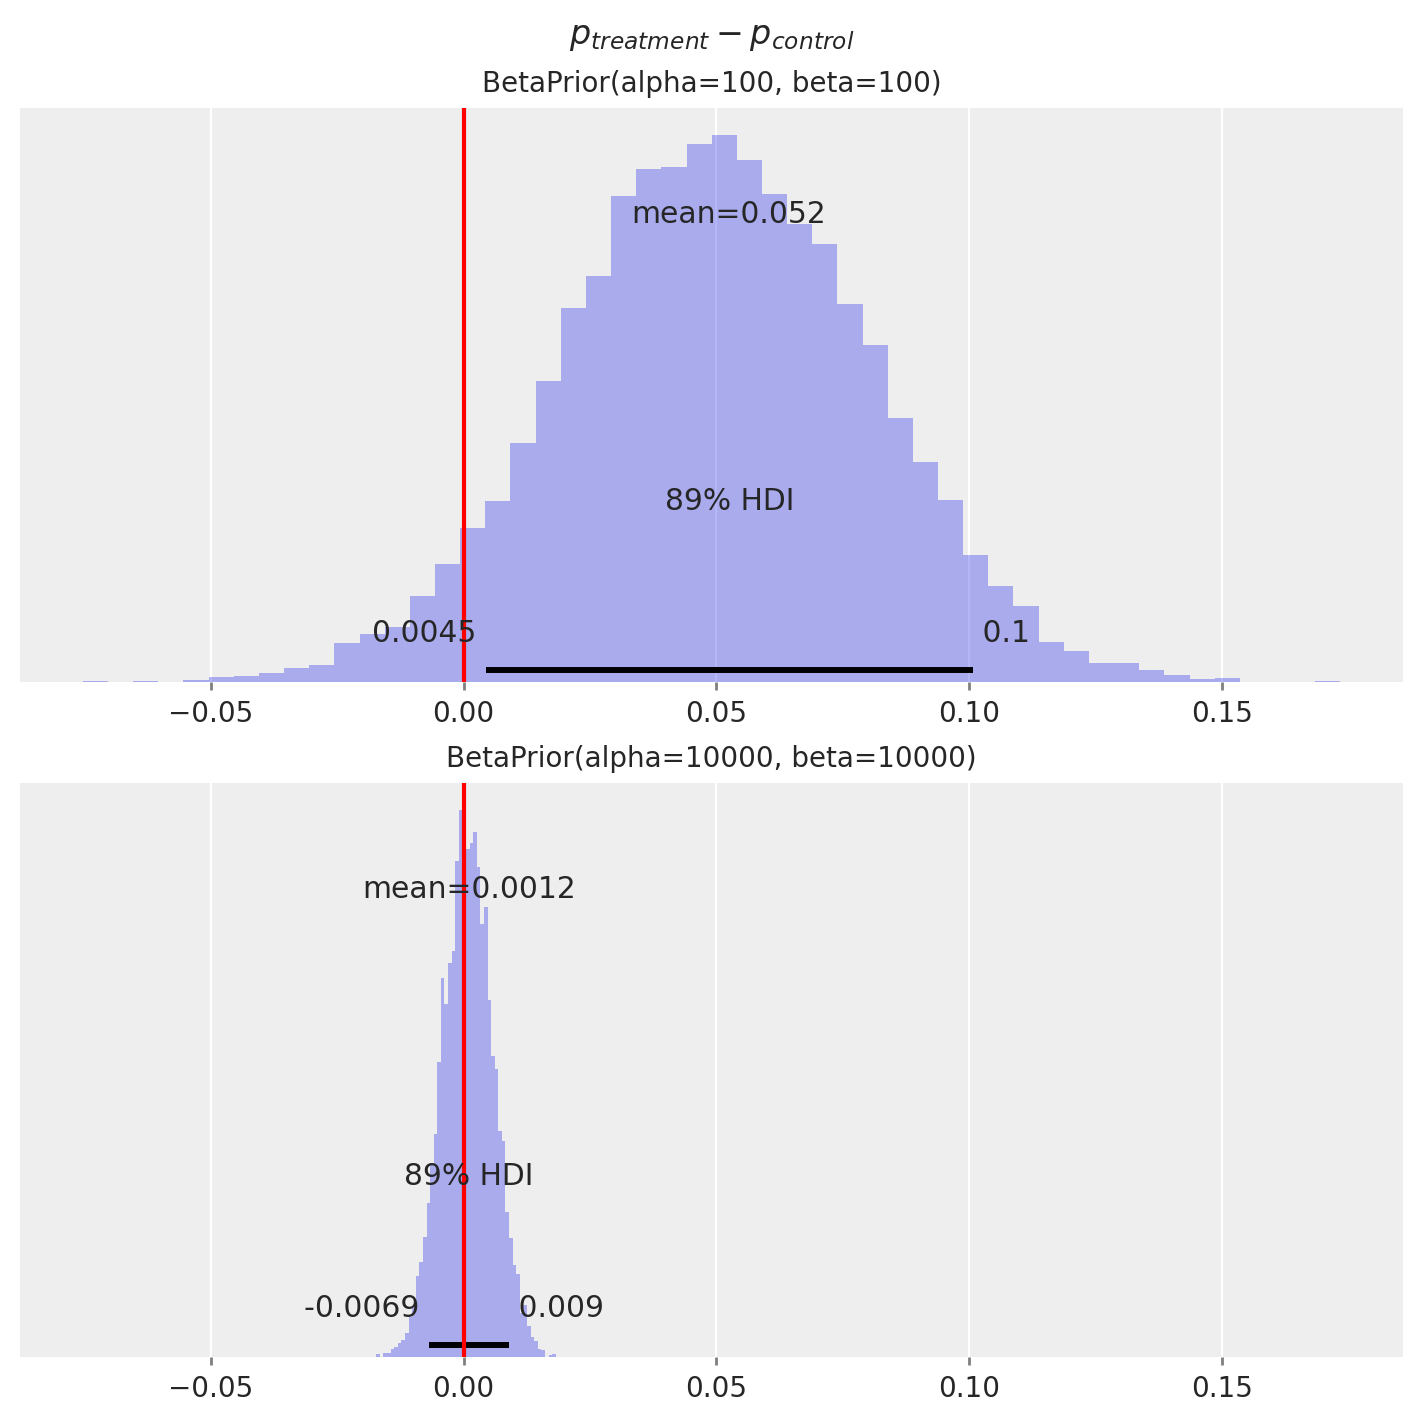

In [26]:
# male
male_ATE_weak, male_ATE_strong = run_ATE(
    data=gender_data_generater(df, female=False),
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)